# Plot data extraction demo

This notebook demonstrate how to extract point data from plot using plot data extraction endpoint.

Current version only support curve plots similar to the example which has no legend.

In [1]:
from jupyter_innotater import *
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
import os
from cognite.client import CogniteClient
import json
import pprint
pp = pprint.PrettyPrinter(indent=2)

## Create a client

To get access to your project, replace "yourproject" with your project name in the next cell. 

When you create the CogniteClient below, getpass will ask for your API key in an extra password field. Simply paste it in and press shift+enter.

In [7]:
project = 'contextualization'
api_key = os.environ.get("COGNITE_CONTEXT_API_KEY")
client = CogniteClient(project=project,
                       api_key=api_key,
                       client_name="dshub",
                      )

/workdata/cognite/projects/dshub-tutorials/.venv/lib/python3.7/site-packages/cognite/client/_cognite_client.py:67: UserWarning: You are using version 2.5.2 of the SDK, however version 2.5.3 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  debug=debug,


## Load an plot example image from CDF
Load an image has a plot, draw a boundingbox on the axes of the plot and copy the value (4 digit values sperated by comma) of the boundingbox to the cell below.

In [2]:
plot_file_id=5912315251967698
client.files.download(directory="./", id=plot_file_id)

NameError: name 'client' is not defined

In [3]:
image = "./example.jpg"
annotations = np.zeros((1, 4))

Innotater(
    ImageInnotation([image], path="./"),
    BoundingBoxInnotation(annotations),
)

Innotater(children=(HBox(children=(VBox(children=(ImagePad(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0…

## Crop the plot indicated by the bounding box from image 

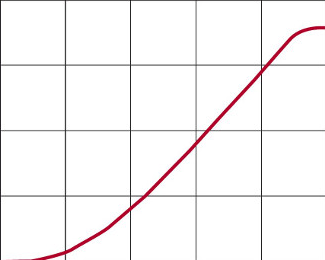

In [4]:
# Copy the values of the above boundingbox here
x1, y1, w, h = 194, 932, 325, 260
# Please input the scale of x-axis and y-axis below, otherwise the default values will be applied
x_min=0
x_max=100
y_min=0
y_max=40
plot_image = Image.open(image).crop((x1, y1, x1 + w, y1 + h))
plot_image

## Convert the image to base64 string

In [5]:
from io import BytesIO
import base64
def image_to_base64_str(image: Image) -> str:
    """Convert image to base64 string
    Parameters
    ----------
    image : image

    Returns: base64 string of the image
    -------

    """
    im_file = BytesIO()
    image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()
    return str(base64.b64encode(im_bytes), "utf-8")

image_string = image_to_base64_str(plot_image)

## Plot data extraction endpoint

### post a request

In [8]:
api_url = f"/api/playground/projects/{project}/context/plotextractor"
extractdata_url = f"{api_url}/extractdata"

post_body = {
    "plotImage": image_string,
    "plotAxes": {"xMin": x_min, "xMax": x_max, "yMin": y_min, "yMax": y_max},
}

res = client.post(url = extractdata_url, json = post_body)
job_id = json.loads(res.text)["jobId"]
print("jobId:", job_id)

jobId: 349222831646873


### get a job

In [9]:
import time
res = client.get(url = f"{api_url}/{job_id}")
while json.loads(res.text)["status"] != "Completed":
        time.sleep(5)
        res = client.get(url = f"{api_url}/{job_id}")

result = json.loads(res.text)["items"]
print(f"{job_id}  {json.loads(res.text)['status']}")

349222831646873  Completed


### Print the extracted points

In [17]:
res.text

'{"items":[{"xPositions":[36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,29

### Plot a curve using extracted points

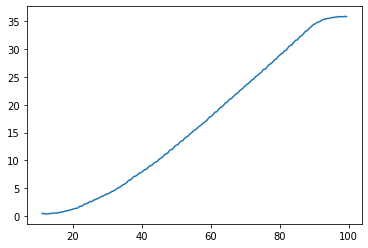

In [28]:
extracted_curves=json.loads(res.text)['items']
for curve in extracted_curves:
    plt.plot(curve.get("xValues"),curve.get("yValues"))